In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pickle, gzip
import numpy as np
import matplotlib.pyplot as plt

In [18]:
path_to_flatland_train_data = 'data/flatland_train.data'

In [19]:
X, y = pickle.load(gzip.open(path_to_flatland_train_data, 'rb'))
# X - data of images
# y - image labels referenced as the number of corners the shape has
# Circle has 0 corners.

In [20]:
X.shape

(10000, 50, 50)

In [21]:
y.shape

(10000,)

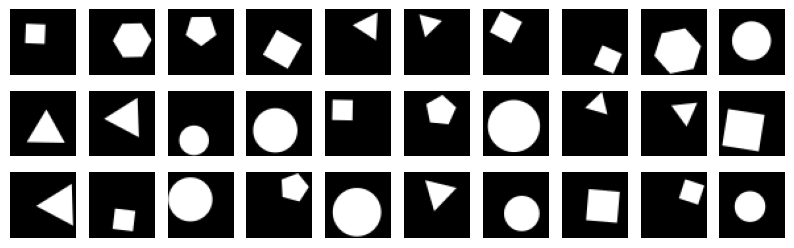

In [22]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()